In [1]:
!pip install qiskit
!pip install qiskit-terra[visualization]

     |████████████████████████████████| 1.6MB 4.9MB/s 
     |████████████████████████████████| 17.3MB 133kB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 983kB 58.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 5.3MB 43.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 532kB 50.7MB/s 
     |████████████████████████████████| 21.7MB 1.3MB/s 
     |████████████████████████████████| 2.3MB 38.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.13.0-cp36-none-any.whl size=1399 sha256=beb4556f49c9461ad7fc67bc9bf18ba4f2fc314b4dcd41f078b22520a1683fc9
  Stored in directory: /root/.cache/pip/wheels/4e/f0/27/e914f739445603aa0229efc

In [0]:
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram

from google.colab import drive

In [3]:
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [5]:
!ls 'drive/My Drive/quant'

no_cloning_theorem.gdoc  qiskit.ipynb


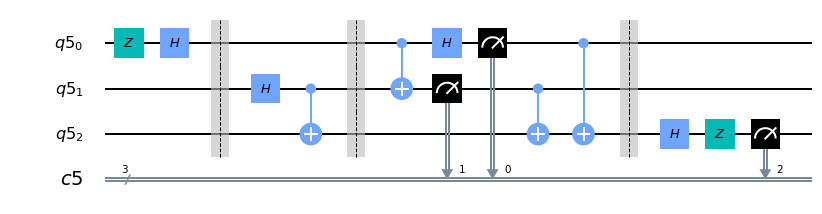

In [19]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
        'x' : quantum_circuit.x,
        'y' : quantum_circuit.y,
        'z' : quantum_circuit.z,
        'h' : quantum_circuit.h,
        't' : quantum_circuit.t,
    }

    if dagger: functionmap['t'] = quantum_circuit.tdg

    if dagger:
        [functionmap[unitary] (qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary] (qubit) for unitary in secret_unitary[::-1]]


secret_unitary = 'hz'

# create the quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. 
# You can change it to any unitary

apply_secret_unitary(secret_unitary, q[0], qc, dagger=0)
qc.barrier()

# Next, generate the entangled pair between Alice and Bob 
# (Remember: Hadamard followed by CX generates a Bell pair)

qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()

# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cx(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''

apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])

qc.draw(output='mpl')

{'000': 263, '111': 278, '010': 242, '101': 241}


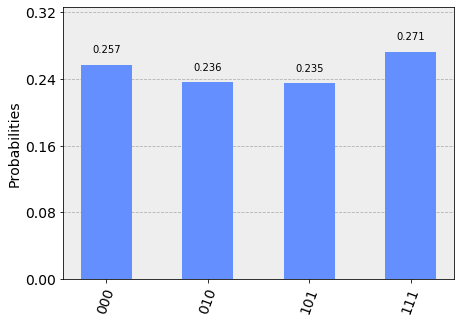

In [23]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

Note that the results on the x-axis in the histogram above are ordered as c2c1c0c2c1c0. We can see that only results where c2=0c2=0 appear, indicating that the teleporation protocol has worked.